##### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Text Classification with Movie Reviews

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/tf2_text_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf2_text_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/tf2_text_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/tf2_text_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/nnlm/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub models</a>
  </td>
</table>

This notebook classifies movie reviews as *positive* or *negative* using the text of the review. This is an example of *binary*—or two-class—classification, an important and widely applicable kind of machine learning problem. 

We'll use the [IMDB dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews. 

This notebook uses [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras), a high-level API to build and train models in TensorFlow, and [TensorFlow Hub](https://www.tensorflow.org/hub), a library and platform for transfer learning. For a more advanced text classification tutorial using `tf.keras`, see the [MLCC Text Classification Guide](https://developers.google.com/machine-learning/guides/text-classification/).

### More models
[Here](https://tfhub.dev/s?module-type=text-embedding) you can find more expressive or performant models that you could use to generate the text embedding.

## Setup

In [3]:
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.9.0-rc1
Eager mode:  True
Hub version:  0.12.0
GPU is available


## Download the IMDB dataset

The IMDB dataset is available on [TensorFlow datasets](https://github.com/tensorflow/datasets). The following code downloads the IMDB dataset to your machine (or the colab runtime):

In [4]:
train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"], 
                                  batch_size=-1, as_supervised=True)

train_examples, train_labels = tfds.as_numpy(train_data)
test_examples, test_labels = tfds.as_numpy(test_data)

## Explore the data 

Let's take a moment to understand the format of the data. Each example is a sentence representing the movie review and a corresponding label. The sentence is not preprocessed in any way. The label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.

In [5]:
print("Training entries: {}, test entries: {}".format(len(train_examples), len(test_examples)))

Training entries: 25000, test entries: 25000


Let's print first 10 examples.

In [6]:
train_examples[:10]

array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot 

Let's also print the first 10 labels.

In [7]:
train_labels[:10]

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])

## Build the model

The neural network is created by stacking layers—this requires three main architectural decisions:

* How to represent the text?
* How many layers to use in the model?
* How many *hidden units* to use for each layer?

In this example, the input data consists of sentences. The labels to predict are either 0 or 1.

One way to represent the text is to convert sentences into embeddings vectors. We can use a pre-trained text embedding as the first layer, which will have two advantages:
*   we don't have to worry about text preprocessing,
*   we can benefit from transfer learning.

For this example we will use a model from [TensorFlow Hub](https://www.tensorflow.org/hub) called [google/nnlm-en-dim50/2](https://tfhub.dev/google/nnlm-en-dim50/2).

There are two other models to test for the sake of this tutorial:
* [google/nnlm-en-dim50-with-normalization/2](https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2) - same as [google/nnlm-en-dim50/2](https://tfhub.dev/google/nnlm-en-dim50/2), but with additional text normalization to remove punctuation. This can help to get better coverage of in-vocabulary embeddings for tokens on your input text.
* [google/nnlm-en-dim128-with-normalization/2](https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2) - A larger model with an embedding dimension of 128 instead of the smaller 50.

Let's first create a Keras layer that uses a TensorFlow Hub model to embed the sentences, and try it out on a couple of input examples. Note that the output shape of the produced embeddings is a expected: `(num_examples, embedding_dimension)`.

In [8]:
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(train_examples[:3])

<tf.Tensor: shape=(3, 50), dtype=float32, numpy=
array([[ 0.5423194 , -0.01190171,  0.06337537,  0.0686297 , -0.16776839,
        -0.10581177,  0.168653  , -0.04998823, -0.31148052,  0.07910344,
         0.15442258,  0.01488661,  0.03930155,  0.19772716, -0.12215477,
        -0.04120982, -0.27041087, -0.21922147,  0.26517656, -0.80739075,
         0.25833526, -0.31004202,  0.2868321 ,  0.19433866, -0.29036498,
         0.0386285 , -0.78444123, -0.04793238,  0.41102988, -0.36388886,
        -0.58034706,  0.30269453,  0.36308962, -0.15227163, -0.4439151 ,
         0.19462997,  0.19528405,  0.05666233,  0.2890704 , -0.28468323,
        -0.00531206,  0.0571938 , -0.3201319 , -0.04418665, -0.08550781,
        -0.55847436, -0.2333639 , -0.20782956, -0.03543065, -0.17533456],
       [ 0.56338924, -0.12339553, -0.10862677,  0.7753425 , -0.07667087,
        -0.15752274,  0.01872334, -0.08169781, -0.3521876 ,  0.46373403,
        -0.08492758,  0.07166861, -0.00670818,  0.12686071, -0.19326551,
 

Let's now build the full model:

In [9]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 keras_layer (KerasLayer)    (None, 50)                48190600  


 dense (Dense)               (None, 16)                816       


 dense_1 (Dense)             (None, 1)                 17        


Total params: 48,191,433


Trainable params: 48,191,433


Non-trainable params: 0


_________________________________________________________________


The layers are stacked sequentially to build the classifier:

1. The first layer is a TensorFlow Hub layer. This layer uses a pre-trained Saved Model to map a sentence into its embedding vector. The model that we are using ([google/nnlm-en-dim50/2](https://tfhub.dev/google/nnlm-en-dim50/2)) splits the sentence into tokens, embeds each token and then combines the embedding. The resulting dimensions are: `(num_examples, embedding_dimension)`.
2. This fixed-length output vector is piped through a fully-connected (`Dense`) layer with 16 hidden units.
3. The last layer is densely connected with a single output node. This outputs logits: the log-odds of the true class, according to the model.

### Hidden units

The above model has two intermediate or "hidden" layers, between the input and output. The number of outputs (units, nodes, or neurons) is the dimension of the representational space for the layer. In other words, the amount of freedom the network is allowed when learning an internal representation.

If a model has more hidden units (a higher-dimensional representation space), and/or more layers, then the network can learn more complex representations. However, it makes the network more computationally expensive and may lead to learning unwanted patterns—patterns that improve performance on training data but not on the test data. This is called *overfitting*, and we'll explore it later.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), we'll use the `binary_crossentropy` loss function. 

This isn't the only choice for a loss function, you could, for instance, choose `mean_squared_error`. But, generally, `binary_crossentropy` is better for dealing with probabilities—it measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and the predictions.

Later, when we are exploring regression problems (say, to predict the price of a house), we will see how to use another loss function called mean squared error.

Now, configure the model to use an optimizer and a loss function:

In [10]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

## Create a validation set

When training, we want to check the accuracy of the model on data it hasn't seen before. Create a *validation set* by setting apart 10,000 examples from the original training data. (Why not use the testing set now? Our goal is to develop and tune our model using only the training data, then use the test data just once to evaluate our accuracy).

In [11]:
x_val = train_examples[:10000]
partial_x_train = train_examples[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

## Train the model

Train the model for 40 epochs in mini-batches of 512 samples. This is 40 iterations over all samples in the `x_train` and `y_train` tensors. While training, monitor the model's loss and accuracy on the 10,000 samples from the validation set:

In [12]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40


 1/30 [>.............................] - ETA: 22s - loss: 0.7221 - accuracy: 0.5059

 3/30 [==>...........................] - ETA: 0s - loss: 0.7020 - accuracy: 0.5339 

 6/30 [=====>........................] - ETA: 0s - loss: 0.6943 - accuracy: 0.5371

 9/30 [========>.....................] - ETA: 0s - loss: 0.6894 - accuracy: 0.5449

12/30 [===========>..................] - ETA: 0s - loss: 0.6830 - accuracy: 0.5591

15/30 [==============>...............] - ETA: 0s - loss: 0.6756 - accuracy: 0.5770

18/30 [=================>............] - ETA: 0s - loss: 0.6706 - accuracy: 0.5878

21/30 [====================>.........] - ETA: 0s - loss: 0.6657 - accuracy: 0.6001

24/30 [=======================>......] - ETA: 0s - loss: 0.6609 - accuracy: 0.6101

27/30 [==========================>...] - ETA: 0s - loss: 0.6565 - accuracy: 0.6194

30/30 [==============================] - ETA: 0s - loss: 0.6525 - accuracy: 0.6263

30/30 [==============================] - 2s 37ms/step - loss: 0.6525 - accuracy: 0.6263 - val_loss: 0.5977 - val_accuracy: 0.7214


Epoch 2/40


 1/30 [>.............................] - ETA: 0s - loss: 0.5789 - accuracy: 0.7559

 4/30 [===>..........................] - ETA: 0s - loss: 0.5749 - accuracy: 0.7563

 7/30 [======>.......................] - ETA: 0s - loss: 0.5734 - accuracy: 0.7531

10/30 [=========>....................] - ETA: 0s - loss: 0.5659 - accuracy: 0.7574

13/30 [============>.................] - ETA: 0s - loss: 0.5593 - accuracy: 0.7638

16/30 [===============>..............] - ETA: 0s - loss: 0.5524 - accuracy: 0.7684

19/30 [==================>...........] - ETA: 0s - loss: 0.5460 - accuracy: 0.7741

22/30 [=====================>........] - ETA: 0s - loss: 0.5399 - accuracy: 0.7781

25/30 [========================>.....] - ETA: 0s - loss: 0.5329 - accuracy: 0.7839

28/30 [===========================>..] - ETA: 0s - loss: 0.5275 - accuracy: 0.7863

30/30 [==============================] - 1s 31ms/step - loss: 0.5255 - accuracy: 0.7871 - val_loss: 0.4824 - val_accuracy: 0.8019


Epoch 3/40


 1/30 [>.............................] - ETA: 0s - loss: 0.4472 - accuracy: 0.8379

 4/30 [===>..........................] - ETA: 0s - loss: 0.4374 - accuracy: 0.8350

 7/30 [======>.......................] - ETA: 0s - loss: 0.4292 - accuracy: 0.8407

10/30 [=========>....................] - ETA: 0s - loss: 0.4205 - accuracy: 0.8475

13/30 [============>.................] - ETA: 0s - loss: 0.4148 - accuracy: 0.8495

16/30 [===============>..............] - ETA: 0s - loss: 0.4098 - accuracy: 0.8510

19/30 [==================>...........] - ETA: 0s - loss: 0.4013 - accuracy: 0.8546

22/30 [=====================>........] - ETA: 0s - loss: 0.3954 - accuracy: 0.8565

25/30 [========================>.....] - ETA: 0s - loss: 0.3903 - accuracy: 0.8581

28/30 [===========================>..] - ETA: 0s - loss: 0.3860 - accuracy: 0.8599

30/30 [==============================] - 1s 31ms/step - loss: 0.3836 - accuracy: 0.8604 - val_loss: 0.3866 - val_accuracy: 0.8415


Epoch 4/40


 1/30 [>.............................] - ETA: 0s - loss: 0.3220 - accuracy: 0.8848

 4/30 [===>..........................] - ETA: 0s - loss: 0.3060 - accuracy: 0.8989

 7/30 [======>.......................] - ETA: 0s - loss: 0.3067 - accuracy: 0.8912

10/30 [=========>....................] - ETA: 0s - loss: 0.3001 - accuracy: 0.8969

13/30 [============>.................] - ETA: 0s - loss: 0.2934 - accuracy: 0.8987

16/30 [===============>..............] - ETA: 0s - loss: 0.2880 - accuracy: 0.9011

19/30 [==================>...........] - ETA: 0s - loss: 0.2848 - accuracy: 0.9011

22/30 [=====================>........] - ETA: 0s - loss: 0.2822 - accuracy: 0.9023

25/30 [========================>.....] - ETA: 0s - loss: 0.2787 - accuracy: 0.9037

28/30 [===========================>..] - ETA: 0s - loss: 0.2765 - accuracy: 0.9030

30/30 [==============================] - 1s 31ms/step - loss: 0.2744 - accuracy: 0.9041 - val_loss: 0.3383 - val_accuracy: 0.8562


Epoch 5/40


 1/30 [>.............................] - ETA: 0s - loss: 0.2135 - accuracy: 0.9375

 4/30 [===>..........................] - ETA: 0s - loss: 0.2190 - accuracy: 0.9316

 7/30 [======>.......................] - ETA: 0s - loss: 0.2113 - accuracy: 0.9364

10/30 [=========>....................] - ETA: 0s - loss: 0.2106 - accuracy: 0.9348

13/30 [============>.................] - ETA: 0s - loss: 0.2094 - accuracy: 0.9343

16/30 [===============>..............] - ETA: 0s - loss: 0.2086 - accuracy: 0.9340

19/30 [==================>...........] - ETA: 0s - loss: 0.2070 - accuracy: 0.9343

22/30 [=====================>........] - ETA: 0s - loss: 0.2035 - accuracy: 0.9349

25/30 [========================>.....] - ETA: 0s - loss: 0.2019 - accuracy: 0.9354

28/30 [===========================>..] - ETA: 0s - loss: 0.1997 - accuracy: 0.9367

30/30 [==============================] - 1s 31ms/step - loss: 0.1999 - accuracy: 0.9364 - val_loss: 0.3172 - val_accuracy: 0.8653


Epoch 6/40


 1/30 [>.............................] - ETA: 0s - loss: 0.1822 - accuracy: 0.9414

 4/30 [===>..........................] - ETA: 0s - loss: 0.1625 - accuracy: 0.9546

 7/30 [======>.......................] - ETA: 0s - loss: 0.1595 - accuracy: 0.9562

10/30 [=========>....................] - ETA: 0s - loss: 0.1572 - accuracy: 0.9564

13/30 [============>.................] - ETA: 0s - loss: 0.1552 - accuracy: 0.9563

16/30 [===============>..............] - ETA: 0s - loss: 0.1519 - accuracy: 0.9579

19/30 [==================>...........] - ETA: 0s - loss: 0.1520 - accuracy: 0.9581

22/30 [=====================>........] - ETA: 0s - loss: 0.1502 - accuracy: 0.9584

25/30 [========================>.....] - ETA: 0s - loss: 0.1479 - accuracy: 0.9592

28/30 [===========================>..] - ETA: 0s - loss: 0.1467 - accuracy: 0.9591

30/30 [==============================] - 1s 31ms/step - loss: 0.1451 - accuracy: 0.9598 - val_loss: 0.3082 - val_accuracy: 0.8713


Epoch 7/40


 1/30 [>.............................] - ETA: 0s - loss: 0.1089 - accuracy: 0.9727

 4/30 [===>..........................] - ETA: 0s - loss: 0.1081 - accuracy: 0.9795

 7/30 [======>.......................] - ETA: 0s - loss: 0.1106 - accuracy: 0.9771

10/30 [=========>....................] - ETA: 0s - loss: 0.1076 - accuracy: 0.9781

13/30 [============>.................] - ETA: 0s - loss: 0.1075 - accuracy: 0.9766

16/30 [===============>..............] - ETA: 0s - loss: 0.1090 - accuracy: 0.9745

19/30 [==================>...........] - ETA: 0s - loss: 0.1067 - accuracy: 0.9758

22/30 [=====================>........] - ETA: 0s - loss: 0.1052 - accuracy: 0.9761

25/30 [========================>.....] - ETA: 0s - loss: 0.1048 - accuracy: 0.9759

28/30 [===========================>..] - ETA: 0s - loss: 0.1047 - accuracy: 0.9754

30/30 [==============================] - 1s 31ms/step - loss: 0.1051 - accuracy: 0.9754 - val_loss: 0.3128 - val_accuracy: 0.8715


Epoch 8/40


 1/30 [>.............................] - ETA: 0s - loss: 0.0819 - accuracy: 0.9844

 4/30 [===>..........................] - ETA: 0s - loss: 0.0829 - accuracy: 0.9863

 7/30 [======>.......................] - ETA: 0s - loss: 0.0800 - accuracy: 0.9872

10/30 [=========>....................] - ETA: 0s - loss: 0.0787 - accuracy: 0.9871

13/30 [============>.................] - ETA: 0s - loss: 0.0785 - accuracy: 0.9869

16/30 [===============>..............] - ETA: 0s - loss: 0.0779 - accuracy: 0.9860

19/30 [==================>...........] - ETA: 0s - loss: 0.0774 - accuracy: 0.9858

22/30 [=====================>........] - ETA: 0s - loss: 0.0769 - accuracy: 0.9852

25/30 [========================>.....] - ETA: 0s - loss: 0.0778 - accuracy: 0.9848

28/30 [===========================>..] - ETA: 0s - loss: 0.0768 - accuracy: 0.9854

30/30 [==============================] - 1s 31ms/step - loss: 0.0766 - accuracy: 0.9853 - val_loss: 0.3239 - val_accuracy: 0.8694


Epoch 9/40


 1/30 [>.............................] - ETA: 0s - loss: 0.0651 - accuracy: 0.9883

 4/30 [===>..........................] - ETA: 0s - loss: 0.0619 - accuracy: 0.9902

 7/30 [======>.......................] - ETA: 0s - loss: 0.0608 - accuracy: 0.9902

10/30 [=========>....................] - ETA: 0s - loss: 0.0595 - accuracy: 0.9912

13/30 [============>.................] - ETA: 0s - loss: 0.0589 - accuracy: 0.9919

16/30 [===============>..............] - ETA: 0s - loss: 0.0591 - accuracy: 0.9915

19/30 [==================>...........] - ETA: 0s - loss: 0.0575 - accuracy: 0.9916

22/30 [=====================>........] - ETA: 0s - loss: 0.0568 - accuracy: 0.9918

25/30 [========================>.....] - ETA: 0s - loss: 0.0563 - accuracy: 0.9923

28/30 [===========================>..] - ETA: 0s - loss: 0.0555 - accuracy: 0.9926

30/30 [==============================] - 1s 31ms/step - loss: 0.0555 - accuracy: 0.9925 - val_loss: 0.3280 - val_accuracy: 0.8709


Epoch 10/40


 1/30 [>.............................] - ETA: 0s - loss: 0.0444 - accuracy: 0.9922

 4/30 [===>..........................] - ETA: 0s - loss: 0.0431 - accuracy: 0.9946

 7/30 [======>.......................] - ETA: 0s - loss: 0.0398 - accuracy: 0.9961

10/30 [=========>....................] - ETA: 0s - loss: 0.0398 - accuracy: 0.9965

13/30 [============>.................] - ETA: 0s - loss: 0.0397 - accuracy: 0.9964

16/30 [===============>..............] - ETA: 0s - loss: 0.0407 - accuracy: 0.9960

19/30 [==================>...........] - ETA: 0s - loss: 0.0406 - accuracy: 0.9958

22/30 [=====================>........] - ETA: 0s - loss: 0.0405 - accuracy: 0.9956

25/30 [========================>.....] - ETA: 0s - loss: 0.0400 - accuracy: 0.9959

28/30 [===========================>..] - ETA: 0s - loss: 0.0393 - accuracy: 0.9960

30/30 [==============================] - 1s 31ms/step - loss: 0.0393 - accuracy: 0.9959 - val_loss: 0.3348 - val_accuracy: 0.8725


Epoch 11/40


 1/30 [>.............................] - ETA: 0s - loss: 0.0331 - accuracy: 0.9980

 4/30 [===>..........................] - ETA: 0s - loss: 0.0297 - accuracy: 0.9976

 7/30 [======>.......................] - ETA: 0s - loss: 0.0292 - accuracy: 0.9978

10/30 [=========>....................] - ETA: 0s - loss: 0.0293 - accuracy: 0.9979

13/30 [============>.................] - ETA: 0s - loss: 0.0291 - accuracy: 0.9980

16/30 [===============>..............] - ETA: 0s - loss: 0.0285 - accuracy: 0.9983

19/30 [==================>...........] - ETA: 0s - loss: 0.0282 - accuracy: 0.9984

22/30 [=====================>........] - ETA: 0s - loss: 0.0282 - accuracy: 0.9982

25/30 [========================>.....] - ETA: 0s - loss: 0.0279 - accuracy: 0.9984

28/30 [===========================>..] - ETA: 0s - loss: 0.0282 - accuracy: 0.9982

30/30 [==============================] - 1s 31ms/step - loss: 0.0285 - accuracy: 0.9982 - val_loss: 0.3465 - val_accuracy: 0.8728


Epoch 12/40


 1/30 [>.............................] - ETA: 0s - loss: 0.0210 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 0s - loss: 0.0227 - accuracy: 0.9995

 7/30 [======>.......................] - ETA: 0s - loss: 0.0241 - accuracy: 0.9994

10/30 [=========>....................] - ETA: 0s - loss: 0.0229 - accuracy: 0.9994

13/30 [============>.................] - ETA: 0s - loss: 0.0224 - accuracy: 0.9992

16/30 [===============>..............] - ETA: 0s - loss: 0.0222 - accuracy: 0.9991

19/30 [==================>...........] - ETA: 0s - loss: 0.0218 - accuracy: 0.9991

22/30 [=====================>........] - ETA: 0s - loss: 0.0217 - accuracy: 0.9989

25/30 [========================>.....] - ETA: 0s - loss: 0.0217 - accuracy: 0.9989

28/30 [===========================>..] - ETA: 0s - loss: 0.0216 - accuracy: 0.9990

30/30 [==============================] - 1s 30ms/step - loss: 0.0214 - accuracy: 0.9990 - val_loss: 0.3585 - val_accuracy: 0.8716


Epoch 13/40


 1/30 [>.............................] - ETA: 0s - loss: 0.0271 - accuracy: 0.9980

 4/30 [===>..........................] - ETA: 0s - loss: 0.0184 - accuracy: 0.9995

 7/30 [======>.......................] - ETA: 0s - loss: 0.0177 - accuracy: 0.9997

10/30 [=========>....................] - ETA: 0s - loss: 0.0175 - accuracy: 0.9994

13/30 [============>.................] - ETA: 0s - loss: 0.0172 - accuracy: 0.9995

16/30 [===============>..............] - ETA: 0s - loss: 0.0171 - accuracy: 0.9995

19/30 [==================>...........] - ETA: 0s - loss: 0.0169 - accuracy: 0.9995

22/30 [=====================>........] - ETA: 0s - loss: 0.0166 - accuracy: 0.9996

25/30 [========================>.....] - ETA: 0s - loss: 0.0164 - accuracy: 0.9996

28/30 [===========================>..] - ETA: 0s - loss: 0.0162 - accuracy: 0.9997

30/30 [==============================] - 1s 31ms/step - loss: 0.0163 - accuracy: 0.9996 - val_loss: 0.3697 - val_accuracy: 0.8691


Epoch 14/40


 1/30 [>.............................] - ETA: 0s - loss: 0.0116 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 0s - loss: 0.0157 - accuracy: 0.9995

 7/30 [======>.......................] - ETA: 0s - loss: 0.0144 - accuracy: 0.9997

10/30 [=========>....................] - ETA: 0s - loss: 0.0138 - accuracy: 0.9998

13/30 [============>.................] - ETA: 0s - loss: 0.0134 - accuracy: 0.9997

16/30 [===============>..............] - ETA: 0s - loss: 0.0131 - accuracy: 0.9996

19/30 [==================>...........] - ETA: 0s - loss: 0.0130 - accuracy: 0.9997

22/30 [=====================>........] - ETA: 0s - loss: 0.0129 - accuracy: 0.9997

25/30 [========================>.....] - ETA: 0s - loss: 0.0129 - accuracy: 0.9998

28/30 [===========================>..] - ETA: 0s - loss: 0.0128 - accuracy: 0.9997

30/30 [==============================] - 1s 31ms/step - loss: 0.0127 - accuracy: 0.9997 - val_loss: 0.3808 - val_accuracy: 0.8690


Epoch 15/40


 1/30 [>.............................] - ETA: 0s - loss: 0.0119 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 0s - loss: 0.0108 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 0s - loss: 0.0104 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 0s - loss: 0.0099 - accuracy: 1.0000

13/30 [============>.................] - ETA: 0s - loss: 0.0099 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 0s - loss: 0.0098 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 0s - loss: 0.0098 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 0.0098 - accuracy: 0.9999

25/30 [========================>.....] - ETA: 0s - loss: 0.0099 - accuracy: 0.9998

28/30 [===========================>..] - ETA: 0s - loss: 0.0102 - accuracy: 0.9998

30/30 [==============================] - 1s 31ms/step - loss: 0.0102 - accuracy: 0.9998 - val_loss: 0.3917 - val_accuracy: 0.8681


Epoch 16/40


 1/30 [>.............................] - ETA: 0s - loss: 0.0086 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 0s - loss: 0.0076 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 0s - loss: 0.0077 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 0s - loss: 0.0079 - accuracy: 1.0000

13/30 [============>.................] - ETA: 0s - loss: 0.0079 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 0s - loss: 0.0079 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 0s - loss: 0.0085 - accuracy: 0.9999

22/30 [=====================>........] - ETA: 0s - loss: 0.0083 - accuracy: 0.9999

25/30 [========================>.....] - ETA: 0s - loss: 0.0083 - accuracy: 0.9999

28/30 [===========================>..] - ETA: 0s - loss: 0.0083 - accuracy: 0.9999

30/30 [==============================] - 1s 31ms/step - loss: 0.0083 - accuracy: 0.9999 - val_loss: 0.4018 - val_accuracy: 0.8679


Epoch 17/40


 1/30 [>.............................] - ETA: 0s - loss: 0.0074 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 0s - loss: 0.0067 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 0s - loss: 0.0068 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 0s - loss: 0.0067 - accuracy: 1.0000

13/30 [============>.................] - ETA: 0s - loss: 0.0072 - accuracy: 0.9998

16/30 [===============>..............] - ETA: 0s - loss: 0.0071 - accuracy: 0.9999

19/30 [==================>...........] - ETA: 0s - loss: 0.0071 - accuracy: 0.9999

22/30 [=====================>........] - ETA: 0s - loss: 0.0069 - accuracy: 0.9999

25/30 [========================>.....] - ETA: 0s - loss: 0.0069 - accuracy: 0.9999

28/30 [===========================>..] - ETA: 0s - loss: 0.0068 - accuracy: 0.9999

30/30 [==============================] - 1s 31ms/step - loss: 0.0068 - accuracy: 0.9999 - val_loss: 0.4107 - val_accuracy: 0.8677


Epoch 18/40


 1/30 [>.............................] - ETA: 0s - loss: 0.0059 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 0s - loss: 0.0058 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 0s - loss: 0.0058 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 0s - loss: 0.0057 - accuracy: 1.0000

13/30 [============>.................] - ETA: 0s - loss: 0.0056 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 0s - loss: 0.0056 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 0s - loss: 0.0056 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 0.0057 - accuracy: 0.9999

25/30 [========================>.....] - ETA: 0s - loss: 0.0056 - accuracy: 0.9999

28/30 [===========================>..] - ETA: 0s - loss: 0.0056 - accuracy: 0.9999

30/30 [==============================] - 1s 31ms/step - loss: 0.0056 - accuracy: 0.9999 - val_loss: 0.4195 - val_accuracy: 0.8675


Epoch 19/40


 1/30 [>.............................] - ETA: 0s - loss: 0.0049 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 0s - loss: 0.0052 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 0s - loss: 0.0050 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 0s - loss: 0.0049 - accuracy: 1.0000

13/30 [============>.................] - ETA: 0s - loss: 0.0048 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 0s - loss: 0.0048 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 0s - loss: 0.0047 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 0.0047 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 0.0047 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 1.0000

30/30 [==============================] - 1s 31ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.4365 - val_accuracy: 0.8664


Epoch 20/40


 1/30 [>.............................] - ETA: 0s - loss: 0.0038 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 0s - loss: 0.0037 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 0s - loss: 0.0037 - accuracy: 1.0000

13/30 [============>.................] - ETA: 0s - loss: 0.0037 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 0s - loss: 0.0037 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 0s - loss: 0.0037 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 0.0036 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 0.0036 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 0.0036 - accuracy: 1.0000

30/30 [==============================] - 1s 31ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.4510 - val_accuracy: 0.8663


Epoch 21/40


 1/30 [>.............................] - ETA: 0s - loss: 0.0032 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 0s - loss: 0.0031 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 0s - loss: 0.0031 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 0s - loss: 0.0031 - accuracy: 1.0000

13/30 [============>.................] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 0.0028 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 0.0028 - accuracy: 1.0000

30/30 [==============================] - 1s 31ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.4658 - val_accuracy: 0.8659


Epoch 22/40


 1/30 [>.............................] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000

13/30 [============>.................] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000

30/30 [==============================] - 1s 31ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.4789 - val_accuracy: 0.8662


Epoch 23/40


 1/30 [>.............................] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000

13/30 [============>.................] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

30/30 [==============================] - 1s 31ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.4910 - val_accuracy: 0.8664


Epoch 24/40


 1/30 [>.............................] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

13/30 [============>.................] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

30/30 [==============================] - 1s 31ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.5021 - val_accuracy: 0.8659


Epoch 25/40


 1/30 [>.............................] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

13/30 [============>.................] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

30/30 [==============================] - 1s 31ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.5128 - val_accuracy: 0.8654


Epoch 26/40


 1/30 [>.............................] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

13/30 [============>.................] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

30/30 [==============================] - 1s 31ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.5224 - val_accuracy: 0.8651


Epoch 27/40


 1/30 [>.............................] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 0s - loss: 9.7784e-04 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000    

10/30 [=========>....................] - ETA: 0s - loss: 9.6291e-04 - accuracy: 1.0000

13/30 [============>.................] - ETA: 0s - loss: 9.6821e-04 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 0s - loss: 9.5702e-04 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 0s - loss: 9.6583e-04 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 9.5926e-04 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 9.5918e-04 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 9.5924e-04 - accuracy: 1.0000

30/30 [==============================] - 1s 31ms/step - loss: 9.5731e-04 - accuracy: 1.0000 - val_loss: 0.5316 - val_accuracy: 0.8648


Epoch 28/40


 1/30 [>.............................] - ETA: 0s - loss: 8.2998e-04 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 0s - loss: 8.5148e-04 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 0s - loss: 8.6846e-04 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 0s - loss: 8.5665e-04 - accuracy: 1.0000

13/30 [============>.................] - ETA: 0s - loss: 8.5253e-04 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 0s - loss: 8.4163e-04 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 0s - loss: 8.4677e-04 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 8.5135e-04 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 8.4729e-04 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 8.4631e-04 - accuracy: 1.0000

30/30 [==============================] - 1s 31ms/step - loss: 8.4013e-04 - accuracy: 1.0000 - val_loss: 0.5401 - val_accuracy: 0.8651


Epoch 29/40


 1/30 [>.............................] - ETA: 0s - loss: 7.2227e-04 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 0s - loss: 7.4390e-04 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 0s - loss: 7.4857e-04 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 0s - loss: 7.6058e-04 - accuracy: 1.0000

13/30 [============>.................] - ETA: 0s - loss: 7.7221e-04 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 0s - loss: 7.6247e-04 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 0s - loss: 7.6311e-04 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 7.5388e-04 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 7.5094e-04 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 7.4178e-04 - accuracy: 1.0000

30/30 [==============================] - 1s 30ms/step - loss: 7.4219e-04 - accuracy: 1.0000 - val_loss: 0.5482 - val_accuracy: 0.8647


Epoch 30/40


 1/30 [>.............................] - ETA: 0s - loss: 7.0372e-04 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 0s - loss: 6.5573e-04 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 0s - loss: 6.5885e-04 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 0s - loss: 6.6354e-04 - accuracy: 1.0000

13/30 [============>.................] - ETA: 0s - loss: 6.6606e-04 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 0s - loss: 6.4997e-04 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 0s - loss: 6.5747e-04 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 6.6476e-04 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 6.6813e-04 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 6.5598e-04 - accuracy: 1.0000

30/30 [==============================] - 1s 30ms/step - loss: 6.5905e-04 - accuracy: 1.0000 - val_loss: 0.5559 - val_accuracy: 0.8646


Epoch 31/40


 1/30 [>.............................] - ETA: 0s - loss: 5.4456e-04 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 0s - loss: 6.1963e-04 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 0s - loss: 5.9851e-04 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 0s - loss: 6.0184e-04 - accuracy: 1.0000

13/30 [============>.................] - ETA: 0s - loss: 5.8529e-04 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 0s - loss: 5.8815e-04 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 0s - loss: 6.0333e-04 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 6.0116e-04 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 5.9321e-04 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 5.9129e-04 - accuracy: 1.0000

30/30 [==============================] - 1s 30ms/step - loss: 5.9167e-04 - accuracy: 1.0000 - val_loss: 0.5632 - val_accuracy: 0.8646


Epoch 32/40


 1/30 [>.............................] - ETA: 0s - loss: 5.2066e-04 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 0s - loss: 5.1808e-04 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 0s - loss: 5.4561e-04 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 0s - loss: 5.4040e-04 - accuracy: 1.0000

13/30 [============>.................] - ETA: 0s - loss: 5.3847e-04 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 0s - loss: 5.4074e-04 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 0s - loss: 5.3976e-04 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 5.4282e-04 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 5.3610e-04 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 5.3355e-04 - accuracy: 1.0000

30/30 [==============================] - 1s 32ms/step - loss: 5.3290e-04 - accuracy: 1.0000 - val_loss: 0.5702 - val_accuracy: 0.8639


Epoch 33/40


 1/30 [>.............................] - ETA: 0s - loss: 4.8303e-04 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 0s - loss: 5.0683e-04 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 0s - loss: 4.9865e-04 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 0s - loss: 4.7674e-04 - accuracy: 1.0000

13/30 [============>.................] - ETA: 0s - loss: 4.7629e-04 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 0s - loss: 4.8605e-04 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 0s - loss: 4.8268e-04 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 4.8380e-04 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 4.8277e-04 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 4.8322e-04 - accuracy: 1.0000

30/30 [==============================] - 1s 31ms/step - loss: 4.8286e-04 - accuracy: 1.0000 - val_loss: 0.5768 - val_accuracy: 0.8639


Epoch 34/40


 1/30 [>.............................] - ETA: 0s - loss: 4.1683e-04 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 0s - loss: 4.4363e-04 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 0s - loss: 4.4643e-04 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 0s - loss: 4.2949e-04 - accuracy: 1.0000

13/30 [============>.................] - ETA: 0s - loss: 4.3973e-04 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 0s - loss: 4.3910e-04 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 0s - loss: 4.4260e-04 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 4.4459e-04 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 4.4228e-04 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 4.4228e-04 - accuracy: 1.0000

30/30 [==============================] - 1s 31ms/step - loss: 4.4023e-04 - accuracy: 1.0000 - val_loss: 0.5831 - val_accuracy: 0.8637


Epoch 35/40


 1/30 [>.............................] - ETA: 0s - loss: 3.5609e-04 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 0s - loss: 4.0348e-04 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 0s - loss: 3.9785e-04 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 0s - loss: 4.1027e-04 - accuracy: 1.0000

13/30 [============>.................] - ETA: 0s - loss: 4.0555e-04 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 0s - loss: 4.1079e-04 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 0s - loss: 4.0591e-04 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 4.0081e-04 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 4.0306e-04 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 4.0470e-04 - accuracy: 1.0000

30/30 [==============================] - 1s 31ms/step - loss: 4.0267e-04 - accuracy: 1.0000 - val_loss: 0.5892 - val_accuracy: 0.8636


Epoch 36/40


 1/30 [>.............................] - ETA: 0s - loss: 2.9451e-04 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 0s - loss: 3.7198e-04 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 0s - loss: 3.7031e-04 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 0s - loss: 3.7265e-04 - accuracy: 1.0000

13/30 [============>.................] - ETA: 0s - loss: 3.7757e-04 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 0s - loss: 3.7240e-04 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 0s - loss: 3.7467e-04 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 3.7210e-04 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 3.7006e-04 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 3.7048e-04 - accuracy: 1.0000

30/30 [==============================] - 1s 31ms/step - loss: 3.6952e-04 - accuracy: 1.0000 - val_loss: 0.5951 - val_accuracy: 0.8636


Epoch 37/40


 1/30 [>.............................] - ETA: 0s - loss: 3.6358e-04 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 0s - loss: 3.6005e-04 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 0s - loss: 3.5258e-04 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 0s - loss: 3.4907e-04 - accuracy: 1.0000

13/30 [============>.................] - ETA: 0s - loss: 3.4745e-04 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 0s - loss: 3.4590e-04 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 0s - loss: 3.4317e-04 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 3.4592e-04 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 3.4293e-04 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 3.4114e-04 - accuracy: 1.0000

30/30 [==============================] - 1s 31ms/step - loss: 3.4044e-04 - accuracy: 1.0000 - val_loss: 0.6008 - val_accuracy: 0.8637


Epoch 38/40


 1/30 [>.............................] - ETA: 0s - loss: 2.8021e-04 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 0s - loss: 3.0118e-04 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 0s - loss: 3.0804e-04 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 0s - loss: 3.1921e-04 - accuracy: 1.0000

13/30 [============>.................] - ETA: 0s - loss: 3.2614e-04 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 0s - loss: 3.2539e-04 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 0s - loss: 3.2193e-04 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 3.1847e-04 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 3.1291e-04 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 3.1387e-04 - accuracy: 1.0000

30/30 [==============================] - 1s 31ms/step - loss: 3.1465e-04 - accuracy: 1.0000 - val_loss: 0.6061 - val_accuracy: 0.8639


Epoch 39/40


 1/30 [>.............................] - ETA: 0s - loss: 2.4328e-04 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 0s - loss: 2.9317e-04 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 0s - loss: 2.8873e-04 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 0s - loss: 2.9221e-04 - accuracy: 1.0000

13/30 [============>.................] - ETA: 0s - loss: 3.0053e-04 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 0s - loss: 3.0197e-04 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 0s - loss: 3.0076e-04 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 2.9881e-04 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 2.9672e-04 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 2.9284e-04 - accuracy: 1.0000

30/30 [==============================] - 1s 31ms/step - loss: 2.9197e-04 - accuracy: 1.0000 - val_loss: 0.6116 - val_accuracy: 0.8638


Epoch 40/40


 1/30 [>.............................] - ETA: 0s - loss: 2.6167e-04 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 0s - loss: 2.7582e-04 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 0s - loss: 2.7215e-04 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 0s - loss: 2.6619e-04 - accuracy: 1.0000

13/30 [============>.................] - ETA: 0s - loss: 2.7099e-04 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 0s - loss: 2.7139e-04 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 0s - loss: 2.7044e-04 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 2.7078e-04 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 2.7230e-04 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 2.7126e-04 - accuracy: 1.0000

30/30 [==============================] - 1s 30ms/step - loss: 2.7158e-04 - accuracy: 1.0000 - val_loss: 0.6167 - val_accuracy: 0.8636


## Evaluate the model

And let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [13]:
results = model.evaluate(test_examples, test_labels)

print(results)

  1/782 [..............................] - ETA: 17s - loss: 0.9022 - accuracy: 0.7812

 18/782 [..............................] - ETA: 2s - loss: 0.7868 - accuracy: 0.8299 

 34/782 [>.............................] - ETA: 2s - loss: 0.7471 - accuracy: 0.8419

 50/782 [>.............................] - ETA: 2s - loss: 0.7037 - accuracy: 0.8506

 67/782 [=>............................] - ETA: 2s - loss: 0.6902 - accuracy: 0.8507

 84/782 [==>...........................] - ETA: 2s - loss: 0.6913 - accuracy: 0.8478

101/782 [==>...........................] - ETA: 2s - loss: 0.7049 - accuracy: 0.8472

118/782 [===>..........................] - ETA: 2s - loss: 0.6679 - accuracy: 0.8501

134/782 [====>.........................] - ETA: 2s - loss: 0.6691 - accuracy: 0.8491

150/782 [====>.........................] - ETA: 1s - loss: 0.6632 - accuracy: 0.8490

167/782 [=====>........................] - ETA: 1s - loss: 0.6622 - accuracy: 0.8507

184/782 [======>.......................] - ETA: 1s - loss: 0.6743 - accuracy: 0.8483

201/782 [======>.......................] - ETA: 1s - loss: 0.6774 - accuracy: 0.8470

218/782 [=======>......................] - ETA: 1s - loss: 0.6845 - accuracy: 0.8472

235/782 [========>.....................] - ETA: 1s - loss: 0.6845 - accuracy: 0.8463

252/782 [========>.....................] - ETA: 1s - loss: 0.6960 - accuracy: 0.8444

269/782 [=========>....................] - ETA: 1s - loss: 0.6942 - accuracy: 0.8447

285/782 [=========>....................] - ETA: 1s - loss: 0.6946 - accuracy: 0.8445

302/782 [==========>...................] - ETA: 1s - loss: 0.6948 - accuracy: 0.8440

319/782 [===========>..................] - ETA: 1s - loss: 0.6876 - accuracy: 0.8447

335/782 [===========>..................] - ETA: 1s - loss: 0.6895 - accuracy: 0.8445

352/782 [============>.................] - ETA: 1s - loss: 0.6869 - accuracy: 0.8456

369/782 [=============>................] - ETA: 1s - loss: 0.6883 - accuracy: 0.8459

386/782 [=============>................] - ETA: 1s - loss: 0.6859 - accuracy: 0.8462

403/782 [==============>...............] - ETA: 1s - loss: 0.6844 - accuracy: 0.8467

419/782 [===============>..............] - ETA: 1s - loss: 0.6895 - accuracy: 0.8460

436/782 [===============>..............] - ETA: 1s - loss: 0.6829 - accuracy: 0.8468

453/782 [================>.............] - ETA: 1s - loss: 0.6810 - accuracy: 0.8469

470/782 [=================>............] - ETA: 0s - loss: 0.6831 - accuracy: 0.8463

487/782 [=================>............] - ETA: 0s - loss: 0.6816 - accuracy: 0.8471

504/782 [==================>...........] - ETA: 0s - loss: 0.6866 - accuracy: 0.8468

521/782 [==================>...........] - ETA: 0s - loss: 0.6879 - accuracy: 0.8465

538/782 [===================>..........] - ETA: 0s - loss: 0.6913 - accuracy: 0.8461

555/782 [====================>.........] - ETA: 0s - loss: 0.6938 - accuracy: 0.8450

571/782 [====================>.........] - ETA: 0s - loss: 0.6953 - accuracy: 0.8447

588/782 [=====================>........] - ETA: 0s - loss: 0.6939 - accuracy: 0.8450

605/782 [======================>.......] - ETA: 0s - loss: 0.6931 - accuracy: 0.8454

622/782 [======================>.......] - ETA: 0s - loss: 0.6911 - accuracy: 0.8455

639/782 [=======================>......] - ETA: 0s - loss: 0.6911 - accuracy: 0.8457

656/782 [========================>.....] - ETA: 0s - loss: 0.6887 - accuracy: 0.8460

673/782 [========================>.....] - ETA: 0s - loss: 0.6873 - accuracy: 0.8460

690/782 [=========================>....] - ETA: 0s - loss: 0.6894 - accuracy: 0.8460

707/782 [==========================>...] - ETA: 0s - loss: 0.6873 - accuracy: 0.8464

723/782 [==========================>...] - ETA: 0s - loss: 0.6904 - accuracy: 0.8466

740/782 [===========================>..] - ETA: 0s - loss: 0.6900 - accuracy: 0.8467

757/782 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.8459

774/782 [============================>.] - ETA: 0s - loss: 0.6942 - accuracy: 0.8461

782/782 [==============================] - 2s 3ms/step - loss: 0.6937 - accuracy: 0.8458


[0.693655788898468, 0.8457599878311157]


This fairly naive approach achieves an accuracy of about 87%. With more advanced approaches, the model should get closer to 95%.

## Create a graph of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [14]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

There are four entries: one for each monitored metric during training and validation. We can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

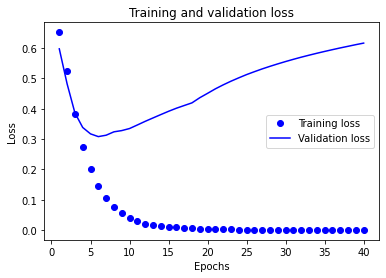

In [15]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

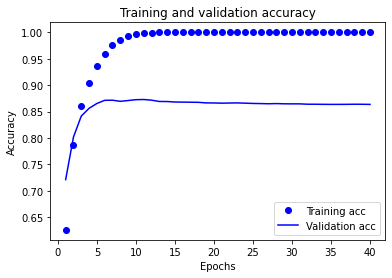

In [16]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak after about twenty epochs. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations *specific* to the training data that do not *generalize* to test data.

For this particular case, we could prevent overfitting by simply stopping the training after twenty or so epochs. Later, you'll see how to do this automatically with a callback.